In [1]:
import os
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"


In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
from dateutil.parser import parse
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, RocCurveDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

## Задание 1

Какова вероятность отправиться на прогулку если идёт дождь, при наличии следующих наблюдений?

```
data = [
        ('солнечно', True),
        ('снег', False),
        ('облачно', False),
        ('дождь', False),
        ('солнечно', True),
        ('снег', False),
        ('облачно', True),
        ('снег', False),
        ('солнечно', False),
        ('облачно', True),
        ('снег', True),
        ('солнечно', True),
        ('дождь', False),
        ('дождь', True),
        ('облачно', True),
]
```


In [3]:
aqua = [
    ('солнечно', True),
    ('снег', False),
    ('облачно', False),
    ('дождь', False),
    ('солнечно', True),
    ('снег', False),
    ('облачно', True),
    ('снег', False),
    ('солнечно', False),
    ('облачно', True),
    ('снег', True),
    ('солнечно', True),
    ('дождь', False),
    ('дождь', True),
    ('облачно', True),
]
df = pd.DataFrame(aqua, columns=['погода', 'прогулка'])
df


,погода,прогулка
0,солнечно,True
1,снег,False
2,облачно,False
3,дождь,False
4,солнечно,True
5,снег,False
6,облачно,True
7,снег,False
8,солнечно,False
9,облачно,True


In [4]:
p_true = len(df[df['прогулка'] == True]) / len(df)
p_false = len(df[df['прогулка'] == False]) / len(df)
# print(p_true * len(df), p_false * len(df))

p_rain_if_true = len(df[(df['прогулка'] == True) & (df['погода'] == 'дождь')]) / len(df[df['прогулка'] == True])
# print(p_rain_if_true * len(df[df['прогулка'] == True]))

p_sunny_if_true = len(df[(df['прогулка'] == True) & (df['погода'] == 'солнечно')]) / len(df[df['прогулка'] == True])
p_snow_if_true = len(df[(df['прогулка'] == True) & (df['погода'] == 'снег')]) / len(df[df['прогулка'] == True])
p_cloudy_if_true = len(df[(df['прогулка'] == True) & (df['погода'] == 'облачно')]) / len(df[df['прогулка'] == True])
# print(p_sunny_if_true * len(df[df['прогулка'] == True]), p_snow_if_true * len(df[df['прогулка'] == True]), p_cloudy_if_true * len(df[df['прогулка'] == True]))

p_rain_if_false = len(df[(df['прогулка'] == False) & (df['погода'] == 'дождь')]) / len(df[df['прогулка'] == False])
# print(p_rain_if_false * len(df[df['прогулка'] == False]))


p_full_rain = p_false * p_rain_if_false + p_true * p_rain_if_true

p_true_if_rain = p_true * p_rain_if_true / p_full_rain
print(f'По формуле Байеса: {p_true_if_rain:.2}')

another = len(df[(df['прогулка'] == True) & (df['погода'] == 'дождь')]) / len(df[df['погода'] == 'дождь'])
print(f'Просто условная вероятность: {another:.2}')

По формуле Байеса: 0.33
Просто условная вероятность: 0.33


## Задание 2

-   загрузите датасет для классификации, проведите предобработку, выделите целевой признак и предикторы, разбейте данные на обучающую и тестовую выборку;
-   Масштабируйте числовые признаки
-   В случае дисбаланса проведите балансировку
-   решите задачу классификации на ваших данных с использованием рассмотренных моделей sklearn: knn, NB, Logistic Regression, SVM. Не забудьте подобрать гиперпараметры.
-   вычислите значения метрик Accuracy, Precision, Recall, F1, ROC AUC score


### Обработка

In [5]:
data = pd.read_csv('../data/weatherAUS.csv', sep=',')
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [6]:
data['Date'] = data['Date'].apply(parse)
data['Day'] = data['Date'].apply(lambda x: x.day)
data['Month'] = data['Date'].apply(lambda x: x.month)
data.drop(columns=['Date'], inplace=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       145460 non-null  object 
 1   MinTemp        143975 non-null  float64
 2   MaxTemp        144199 non-null  float64
 3   Rainfall       142199 non-null  float64
 4   Evaporation    82670 non-null   float64
 5   Sunshine       75625 non-null   float64
 6   WindGustDir    135134 non-null  object 
 7   WindGustSpeed  135197 non-null  float64
 8   WindDir9am     134894 non-null  object 
 9   WindDir3pm     141232 non-null  object 
 10  WindSpeed9am   143693 non-null  float64
 11  WindSpeed3pm   142398 non-null  float64
 12  Humidity9am    142806 non-null  float64
 13  Humidity3pm    140953 non-null  float64
 14  Pressure9am    130395 non-null  float64
 15  Pressure3pm    130432 non-null  float64
 16  Cloud9am       89572 non-null   float64
 17  Cloud3pm       86102 non-null

In [8]:
for col in (
    'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am',
        'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm'):
    data[col].fillna(data[col].mean(), inplace=True)

for col in ('WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow'):
    data[col].fillna(data[col].mode()[0], inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       145460 non-null  object 
 1   MinTemp        145460 non-null  float64
 2   MaxTemp        145460 non-null  float64
 3   Rainfall       145460 non-null  float64
 4   Evaporation    145460 non-null  float64
 5   Sunshine       145460 non-null  float64
 6   WindGustDir    145460 non-null  object 
 7   WindGustSpeed  145460 non-null  float64
 8   WindDir9am     145460 non-null  object 
 9   WindDir3pm     145460 non-null  object 
 10  WindSpeed9am   145460 non-null  float64
 11  WindSpeed3pm   145460 non-null  float64
 12  Humidity9am    145460 non-null  float64
 13  Humidity3pm    145460 non-null  float64
 14  Pressure9am    145460 non-null  float64
 15  Pressure3pm    145460 non-null  float64
 16  Cloud9am       145460 non-null  float64
 17  Cloud3pm       145460 non-nul

In [9]:
for col in ('RainToday', 'RainTomorrow'):
    data[col] = data[col].map({'No': 0, 'Yes': 1})

data

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Day,Month
0,Albury,13.4,22.900000,0.6,5.468232,7.611178,W,44.00000,W,WNW,...,1007.7,1007.1,8.000000,4.50993,16.9,21.8,0,0,1,12
1,Albury,7.4,25.100000,0.0,5.468232,7.611178,WNW,44.00000,NNW,WSW,...,1010.6,1007.8,4.447461,4.50993,17.2,24.3,0,0,2,12
2,Albury,12.9,25.700000,0.0,5.468232,7.611178,WSW,46.00000,W,WSW,...,1007.6,1008.7,4.447461,2.00000,21.0,23.2,0,0,3,12
3,Albury,9.2,28.000000,0.0,5.468232,7.611178,NE,24.00000,SE,E,...,1017.6,1012.8,4.447461,4.50993,18.1,26.5,0,0,4,12
4,Albury,17.5,32.300000,1.0,5.468232,7.611178,W,41.00000,ENE,NW,...,1010.8,1006.0,7.000000,8.00000,17.8,29.7,0,0,5,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,Uluru,2.8,23.400000,0.0,5.468232,7.611178,E,31.00000,SE,ENE,...,1024.6,1020.3,4.447461,4.50993,10.1,22.4,0,0,21,6
145456,Uluru,3.6,25.300000,0.0,5.468232,7.611178,NNW,22.00000,SE,N,...,1023.5,1019.1,4.447461,4.50993,10.9,24.5,0,0,22,6
145457,Uluru,5.4,26.900000,0.0,5.468232,7.611178,N,37.00000,SE,WNW,...,1021.0,1016.8,4.447461,4.50993,12.5,26.1,0,0,23,6
145458,Uluru,7.8,27.000000,0.0,5.468232,7.611178,SE,28.00000,SSE,N,...,1019.4,1016.5,3.000000,2.00000,15.1,26.0,0,0,24,6


In [10]:
for col in ('Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'):
    temp = data[col].value_counts(dropna=False)
    print(f'{col}\t{temp.count()}')
    display(temp)
    print('=====================================')

Location	49


Canberra            3436
Sydney              3344
Darwin              3193
Melbourne           3193
Brisbane            3193
Adelaide            3193
Perth               3193
Hobart              3193
Albany              3040
MountGambier        3040
Ballarat            3040
Townsville          3040
GoldCoast           3040
Cairns              3040
Launceston          3040
AliceSprings        3040
Bendigo             3040
Albury              3040
MountGinini         3040
Wollongong          3040
Newcastle           3039
Tuggeranong         3039
Penrith             3039
Woomera             3009
Nuriootpa           3009
Cobar               3009
CoffsHarbour        3009
Moree               3009
Sale                3009
PerthAirport        3009
PearceRAAF          3009
Witchcliffe         3009
BadgerysCreek       3009
Mildura             3009
NorfolkIsland       3009
MelbourneAirport    3009
Richmond            3009
SydneyAirport       3009
WaggaWagga          3009
Williamtown         3009


WindGustDir	16


W      20241
SE      9418
N       9313
SSE     9216
E       9181
S       9168
WSW     9069
SW      8967
SSW     8736
WNW     8252
NW      8122
ENE     8104
ESE     7372
NE      7133
NNW     6620
NNE     6548
Name: WindGustDir, dtype: int64

WindDir9am	16


N      22324
SE      9287
E       9176
SSE     9112
NW      8749
S       8659
W       8459
SW      8423
NNE     8129
NNW     7980
ENE     7836
NE      7671
ESE     7630
SSW     7587
WNW     7414
WSW     7024
Name: WindDir9am, dtype: int64

WindDir3pm	16


SE     15066
W      10110
S       9926
WSW     9518
SSE     9399
SW      9354
N       8890
WNW     8874
NW      8610
ESE     8505
E       8472
NE      8263
SSW     8156
NNW     7870
ENE     7857
NNE     6590
Name: WindDir3pm, dtype: int64

In [11]:
dirs = data['WindGustDir'].unique()
for col in ('WindGustDir', 'WindDir9am', 'WindDir3pm'):
    data[col] = data[col].map({k: v for v, k in enumerate(dirs)})

data

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Day,Month
0,Albury,13.4,22.900000,0.6,5.468232,7.611178,0,44.00000,0,1,...,1007.7,1007.1,8.000000,4.50993,16.9,21.8,0,0,1,12
1,Albury,7.4,25.100000,0.0,5.468232,7.611178,1,44.00000,4,2,...,1010.6,1007.8,4.447461,4.50993,17.2,24.3,0,0,2,12
2,Albury,12.9,25.700000,0.0,5.468232,7.611178,2,46.00000,0,2,...,1007.6,1008.7,4.447461,2.00000,21.0,23.2,0,0,3,12
3,Albury,9.2,28.000000,0.0,5.468232,7.611178,3,24.00000,12,14,...,1017.6,1012.8,4.447461,4.50993,18.1,26.5,0,0,4,12
4,Albury,17.5,32.300000,1.0,5.468232,7.611178,0,41.00000,8,11,...,1010.8,1006.0,7.000000,8.00000,17.8,29.7,0,0,5,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,Uluru,2.8,23.400000,0.0,5.468232,7.611178,14,31.00000,12,8,...,1024.6,1020.3,4.447461,4.50993,10.1,22.4,0,0,21,6
145456,Uluru,3.6,25.300000,0.0,5.468232,7.611178,4,22.00000,12,5,...,1023.5,1019.1,4.447461,4.50993,10.9,24.5,0,0,22,6
145457,Uluru,5.4,26.900000,0.0,5.468232,7.611178,5,37.00000,12,1,...,1021.0,1016.8,4.447461,4.50993,12.5,26.1,0,0,23,6
145458,Uluru,7.8,27.000000,0.0,5.468232,7.611178,12,28.00000,9,5,...,1019.4,1016.5,3.000000,2.00000,15.1,26.0,0,0,24,6


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       145460 non-null  object 
 1   MinTemp        145460 non-null  float64
 2   MaxTemp        145460 non-null  float64
 3   Rainfall       145460 non-null  float64
 4   Evaporation    145460 non-null  float64
 5   Sunshine       145460 non-null  float64
 6   WindGustDir    145460 non-null  int64  
 7   WindGustSpeed  145460 non-null  float64
 8   WindDir9am     145460 non-null  int64  
 9   WindDir3pm     145460 non-null  int64  
 10  WindSpeed9am   145460 non-null  float64
 11  WindSpeed3pm   145460 non-null  float64
 12  Humidity9am    145460 non-null  float64
 13  Humidity3pm    145460 non-null  float64
 14  Pressure9am    145460 non-null  float64
 15  Pressure3pm    145460 non-null  float64
 16  Cloud9am       145460 non-null  float64
 17  Cloud3pm       145460 non-nul

In [13]:
# data = pd.get_dummies(data, ['Location'])
data['Location'] = data['Location'].map({k: v for v, k in enumerate(data['Location'].unique())})

data

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Day,Month
0,0,13.4,22.900000,0.6,5.468232,7.611178,0,44.00000,0,1,...,1007.7,1007.1,8.000000,4.50993,16.9,21.8,0,0,1,12
1,0,7.4,25.100000,0.0,5.468232,7.611178,1,44.00000,4,2,...,1010.6,1007.8,4.447461,4.50993,17.2,24.3,0,0,2,12
2,0,12.9,25.700000,0.0,5.468232,7.611178,2,46.00000,0,2,...,1007.6,1008.7,4.447461,2.00000,21.0,23.2,0,0,3,12
3,0,9.2,28.000000,0.0,5.468232,7.611178,3,24.00000,12,14,...,1017.6,1012.8,4.447461,4.50993,18.1,26.5,0,0,4,12
4,0,17.5,32.300000,1.0,5.468232,7.611178,0,41.00000,8,11,...,1010.8,1006.0,7.000000,8.00000,17.8,29.7,0,0,5,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,48,2.8,23.400000,0.0,5.468232,7.611178,14,31.00000,12,8,...,1024.6,1020.3,4.447461,4.50993,10.1,22.4,0,0,21,6
145456,48,3.6,25.300000,0.0,5.468232,7.611178,4,22.00000,12,5,...,1023.5,1019.1,4.447461,4.50993,10.9,24.5,0,0,22,6
145457,48,5.4,26.900000,0.0,5.468232,7.611178,5,37.00000,12,1,...,1021.0,1016.8,4.447461,4.50993,12.5,26.1,0,0,23,6
145458,48,7.8,27.000000,0.0,5.468232,7.611178,12,28.00000,9,5,...,1019.4,1016.5,3.000000,2.00000,15.1,26.0,0,0,24,6


In [14]:
for col in set(data.columns) - {'RainToday', 'RainTomorrow'}:
    data[col] = (data[col] - np.mean(data[col])) / np.std(data[col])
data.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Day,Month
0,-1.689897,0.189447,-0.045336,-0.210072,-2.809331e-16,-6.508050e-16,-1.429626,0.302234,-1.677294,-1.424246,...,-1.478788,-1.223882,1.568037e+00,-8.487347e-16,-0.014053,0.017023,0,0,-1.672844,1.634076
1,-1.689897,-0.753101,0.265043,-0.281650,-2.809331e-16,-6.508050e-16,-1.225773,0.302234,-0.770458,-1.208871,...,-1.047782,-1.118839,-3.920285e-16,-8.487347e-16,0.032464,0.381985,0,0,-1.559140,1.634076
2,-1.689897,0.110901,0.349692,-0.281650,-2.809331e-16,-6.508050e-16,-1.021920,0.454694,-1.677294,-1.208871,...,-1.493650,-0.983784,-3.920285e-16,-1.199232e+00,0.621685,0.221402,0,0,-1.445436,1.634076
3,-1.689897,-0.470337,0.674180,-0.281650,-2.809331e-16,-6.508050e-16,-0.818067,-1.222364,1.043213,1.375625,...,-0.007422,-0.368534,-3.920285e-16,-8.487347e-16,0.172017,0.703151,0,0,-1.331732,1.634076
4,-1.689897,0.833521,1.280830,-0.162353,-2.809331e-16,-6.508050e-16,-1.429626,0.073544,0.136378,0.729501,...,-1.018057,-1.388949,1.126652e+00,1.667539e+00,0.125499,1.170302,0,0,-1.218028,1.634076


In [15]:
X = data.drop(columns=['RainTomorrow'])
y = data['RainTomorrow']
X.shape, y.shape

((145460, 23), (145460,))

In [16]:
sm = SMOTE(random_state=73, k_neighbors=5)
X, y = sm.fit_resample(X, y)
X.shape, y.shape

((227166, 23), (227166,))

### train test split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

### Обучение

In [18]:
params = {
    'metric': ['minkowski'],
    'p': [2],
    'n_neighbors': [7, 11, 13],
    'leaf_size': [20, 25, 30],
}

params = {
    'metric': ['minkowski'],
    'p': [2],
    'n_neighbors': [11],
    'leaf_size': [25],
}

In [19]:
knn = GridSearchCV(KNeighborsClassifier(), params).fit(X_train, y_train)
y_knn_pred = knn.predict(X_test)
knn.best_params_

{'leaf_size': 25, 'metric': 'minkowski', 'n_neighbors': 11, 'p': 2}

In [20]:
print(confusion_matrix(y_test, y_knn_pred))
print(classification_report(y_test, y_knn_pred))

[[27365 10074]
 [ 2657 34869]]
              precision    recall  f1-score   support

           0       0.91      0.73      0.81     37439
           1       0.78      0.93      0.85     37526

    accuracy                           0.83     74965
   macro avg       0.84      0.83      0.83     74965
weighted avg       0.84      0.83      0.83     74965



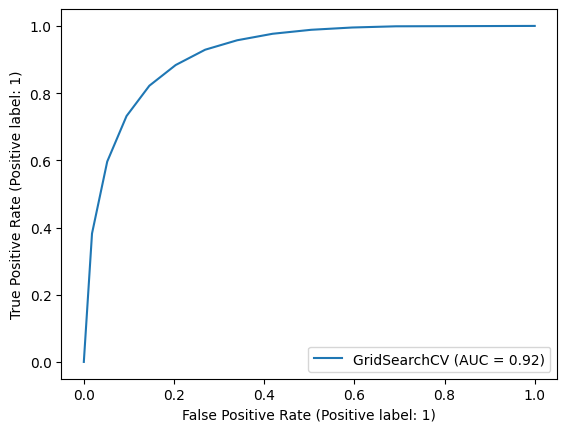

In [21]:
RocCurveDisplay.from_estimator(knn, X_test, y_test)  # до SMOTE 0.8.., после - 0.92

In [22]:
gnb = GaussianNB().fit(X_train, y_train)
y_gnb_pred = gnb.predict(X_test)

In [23]:
print(confusion_matrix(y_test, y_gnb_pred))
print(classification_report(y_test, y_gnb_pred))

[[29847  7592]
 [11683 25843]]
              precision    recall  f1-score   support

           0       0.72      0.80      0.76     37439
           1       0.77      0.69      0.73     37526

    accuracy                           0.74     74965
   macro avg       0.75      0.74      0.74     74965
weighted avg       0.75      0.74      0.74     74965



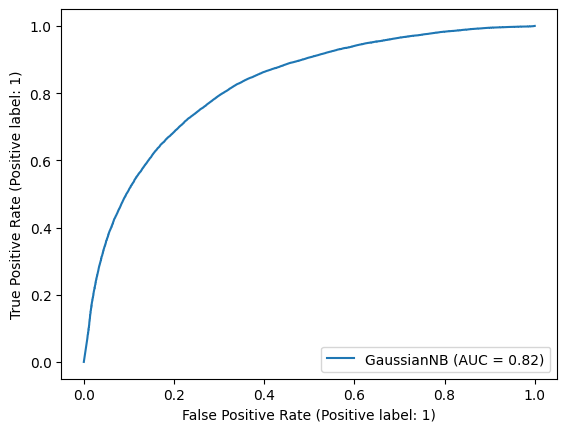

In [24]:
RocCurveDisplay.from_estimator(gnb, X_test, y_test)  # до SMOTE 0.83, после - 0.83

In [25]:
params = {
    'max_iter': range(90, 150, 10),
}
params = {
    'max_iter': [130],
}

clf = GridSearchCV(LogisticRegression(), params).fit(X_train, y_train)
y_clf_pred = clf.predict(X_test)
clf.best_params_

{'max_iter': 130}

In [26]:
print(confusion_matrix(y_test, y_clf_pred))
print(classification_report(y_test, y_clf_pred))

[[29663  7776]
 [ 8860 28666]]
              precision    recall  f1-score   support

           0       0.77      0.79      0.78     37439
           1       0.79      0.76      0.78     37526

    accuracy                           0.78     74965
   macro avg       0.78      0.78      0.78     74965
weighted avg       0.78      0.78      0.78     74965



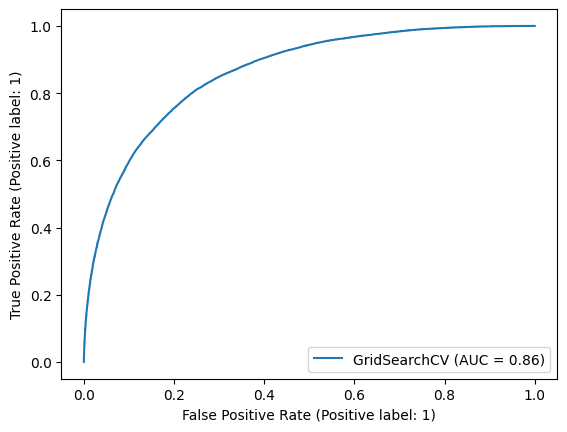

In [27]:
RocCurveDisplay.from_estimator(clf, X_test, y_test)  # 0.86 -> 0.87

In [28]:
svc = SVC().fit(X_train[:100], y_train[:100])
y_svc_pred = svc.predict(X_test)

In [29]:
print(confusion_matrix(y_test, y_svc_pred))
print(classification_report(y_test, y_svc_pred))

[[32537  4902]
 [16727 20799]]
              precision    recall  f1-score   support

           0       0.66      0.87      0.75     37439
           1       0.81      0.55      0.66     37526

    accuracy                           0.71     74965
   macro avg       0.73      0.71      0.70     74965
weighted avg       0.73      0.71      0.70     74965



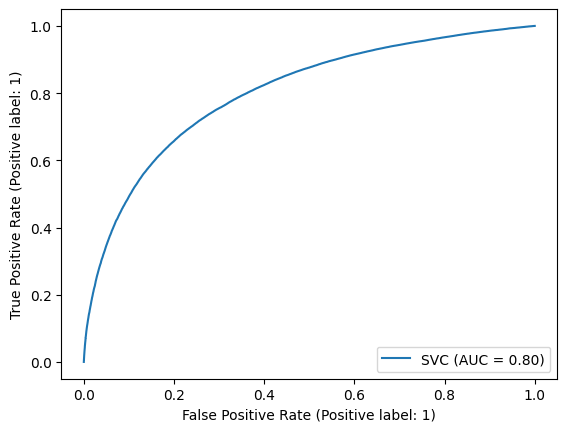

In [30]:
RocCurveDisplay.from_estimator(svc, X, y)
# на обучении [:100] результат 0.80
# на обучении [:1000] результат 0.85
# на обучении [:10000] результат 0.87

## Задание 3

-   Самостоятельно реализуйте метрики Accuracy, Precision, Recall, F1
-   Самостоятельно реализуйте kNN и Naive Bayes


In [31]:
if (dir := str(Path(os.getcwd()).parent)) not in sys.path:
    sys.path.append(dir)
sys.path

from mylib.metrics import CMetrics
from mylib.knn import KnnClassifier
from mylib.naive_bayes import NaiveBayes

In [32]:
print(classification_report(y_test, y_knn_pred))

              precision    recall  f1-score   support

           0       0.91      0.73      0.81     37439
           1       0.78      0.93      0.85     37526

    accuracy                           0.83     74965
   macro avg       0.84      0.83      0.83     74965
weighted avg       0.84      0.83      0.83     74965



In [33]:
CMetrics(y_test, y_knn_pred)()

	precision	recall	f1-score
0	     0.91	  0.73	    0.81
1	     0.78	  0.93	    0.85
accuracy			    0.83



In [34]:
my_knn = KnnClassifier(n_neighbors=5).fit(X_train[:1500], y_train[:1500])
my_pred = my_knn.predict(X_test[:1500])

In [35]:
CMetrics(y_test, my_pred)()

	precision	recall	f1-score
0	     0.72	  0.65	    0.68
1	     0.69	  0.76	    0.73
accuracy			    0.71



In [36]:
for k, v in zip(*np.unique(y_train, return_counts=True)):
    print(k, v)

0 76144
1 76057


In [37]:
my_nbayes = NaiveBayes().fit(X_train, y_train)
my_nb_pred = my_nbayes.predict(X_test)
my_nb_pred

array([0, 0, 1, ..., 1, 1, 1], dtype=int64)

In [38]:
CMetrics(y_test, my_nb_pred)()

	precision	recall	f1-score
0	     0.72	  0.80	    0.76
1	     0.77	  0.69	    0.73
accuracy			    0.74



## Дополнительные баллы

-   Самостоятельно реализуйте SVM с возможностью выбирать ядро.
